Data Table:
+--------------+----------------------+
|merchant_state|avg_transaction_amount|
+--------------+----------------------+
|            AZ|     52.13027625624414|
|            SC|      48.6620380850927|
|            LA|     49.16244466958723|
|            MN|     52.65442701110881|
|     Singapore|     93.01250171661377|
|            NJ|      56.0955652535302|
|            DC|    51.135470459412986|
|       Germany|     74.08726078841997|
|            OR|    44.500828149204914|
|        France|     60.90376903185478|
|        Greece|    60.299508600938516|
|        Taiwan|     228.6800002257029|
|            VA|    59.289047198970664|
|          NULL|     59.78387513540243|
|            RI|     57.80173329640156|
|            KY|     47.71285084883547|
|            WY|     52.82912921438369|
|            NH|     47.95347626947865|
|            MI|     47.39215949220126|
|            NV|     84.55116537641813|
+--------------+----------------------+
only showing top 20 rows



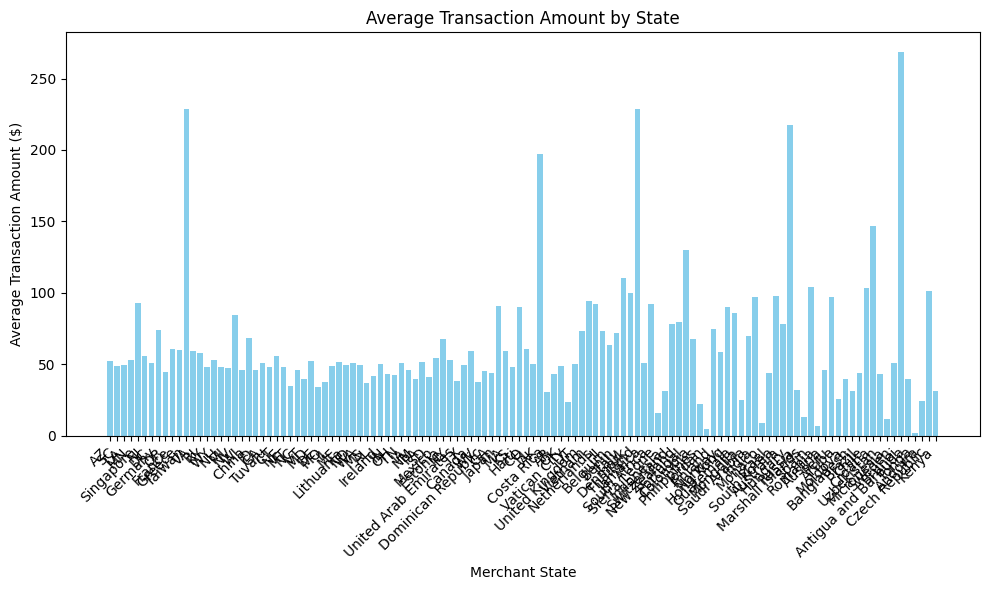

In [1]:
###   Goal 1 calculate the average transaction amount for each state (merchant_state)

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, when, count
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("BigDataProject").getOrCreate()
df = spark.read.format('csv').option('header', 'true').csv('DataSet.csv')

df = df.withColumn("clean_amount", col("amount").substr(2, 10).cast("float"))

# Calculate the average transaction amount by state
avg_transaction_by_state = df.groupBy("merchant_state") \
    .agg(avg("clean_amount").alias("avg_transaction_amount"))

# Show the cleaned data
print("Data Table:")
avg_transaction_by_state.show()

# Collect the data for visualization, filtering out null values
data = avg_transaction_by_state.filter(
    (col("merchant_state").isNotNull()) & (col("avg_transaction_amount").isNotNull())
).collect()

# Extract states and average transaction amounts
states = [row['merchant_state'] for row in data]
avg_amounts = [row['avg_transaction_amount'] for row in data]

# Plot the data using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(states, avg_amounts, color='skyblue')
plt.xlabel('Merchant State')
plt.ylabel('Average Transaction Amount ($)')
plt.title('Average Transaction Amount by State')
plt.xticks(rotation=45, ha='right')  # Rotate state names for better readability
plt.tight_layout()
plt.show()

In [2]:
# Goal 2 Merchant Risk Profiling
from pyspark.sql.functions import sum

# 1. Count transaction errors per merchant
errors_per_merchant = df.filter(col("errors").isNotNull()) \
    .groupBy("merchant_id") \
    .agg(count("*").alias("error_count"))

# 2. Count transaction volume (number of transactions) per merchant
volume_per_merchant = df.groupBy("merchant_id") \
    .agg(count("*").alias("transaction_volume"))

# 3. Calculate total transaction amount per merchant
amount_per_merchant = df.groupBy("merchant_id") \
    .agg(sum("clean_amount").alias("total_transaction_amount"))

# 4. Join the results to combine all merchant metrics
merchant_profile = errors_per_merchant \
    .join(volume_per_merchant, on="merchant_id", how="left") \
    .join(amount_per_merchant, on="merchant_id", how="left")

# 5. Define a risk score based on transaction errors, volume, and amount
merchant_profile = merchant_profile.withColumn(
    "risk_score",
    (col("error_count") * 0.4) +  # Weight for error count
    (col("transaction_volume") * 0.3) +  # Weight for transaction volume
    (col("total_transaction_amount") * 0.3)  # Weight for total transaction amount
)

# 6. Sort by risk score (highest risk first)
merchant_profile_sorted = merchant_profile.orderBy(col("risk_score").desc())

merchant_profile_sorted.show()

+-----------+-----------+------------------+------------------------+------------------+
|merchant_id|error_count|transaction_volume|total_transaction_amount|        risk_score|
+-----------+-----------+------------------+------------------------+------------------+
|      27092|       1472|             47918|               4295920.0|         1303740.2|
|      59935|        880|             49493|      1814699.6599991042| 559609.7979997313|
|      61195|        673|             45332|      1687726.1996465176| 520186.6598939553|
|      60569|        487|             24280|      1520559.8500116207| 463646.7550034862|
|      43293|        493|             29804|       1123683.839966692|346243.55199000763|
|      39021|        582|             29852|      1055022.6698790789|325695.20096372365|
|      22204|        469|             27750|      1008859.4999713693| 311170.4499914108|
|      73186|        200|              6941|       780652.6101258695|236358.08303776084|
|      20561|        

+--------------+-----------+
|merchant_state|error_count|
+--------------+-----------+
|            AZ|        257|
|            SC|        221|
|            LA|        227|
|            MN|        256|
|            NJ|        354|
|            DC|         16|
|       Germany|          3|
|            OR|        136|
|            VA|        248|
|          NULL|       2599|
|            RI|         70|
|            KY|        164|
|            WY|          8|
|            NH|         58|
|            MI|        407|
|            NV|         87|
|            WI|        219|
|            ID|         87|
|            CA|       1937|
|            CT|        161|
+--------------+-----------+
only showing top 20 rows



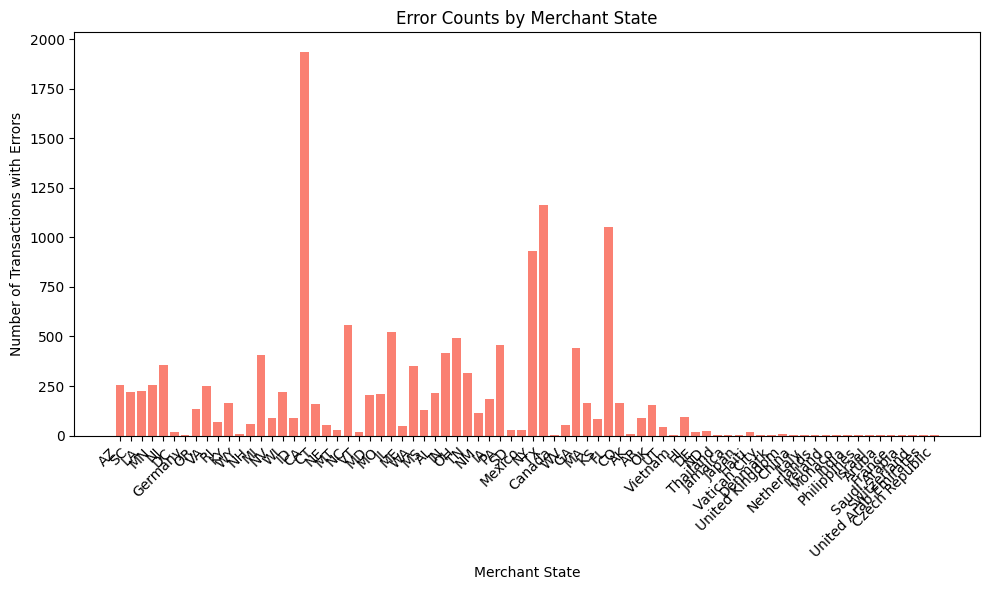

In [3]:
### Goal 3  Count the number of transactions that have errors, grouped by merchant_state

from pyspark.sql.functions import count

# Filter transactions with errors and group by merchant_state
errors_by_state = df.filter(col("errors").isNotNull()) \
    .groupBy("merchant_state") \
    .agg(count("*").alias("error_count"))

errors_by_state.show()

data = errors_by_state.filter(col("merchant_state").isNotNull()).collect()

# Extract states and error counts
states = [row['merchant_state'] for row in data]
error_counts = [row['error_count'] for row in data]

# Plot the data using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(states, error_counts, color='salmon')
plt.xlabel('Merchant State')
plt.ylabel('Number of Transactions with Errors')
plt.title('Error Counts by Merchant State')
plt.xticks(rotation=45, ha='right')  # Rotate state names for better readability
plt.tight_layout()
plt.show()

+----+-----------------+
| mcc|transaction_count|
+----+-----------------+
|5411|           124721|
|5499|           116374|
|5541|           114575|
|5812|            78224|
|5912|            61122|
|5300|            48207|
|4829|            47918|
|4784|            46150|
|5814|            39150|
|4121|            38361|
+----+-----------------+



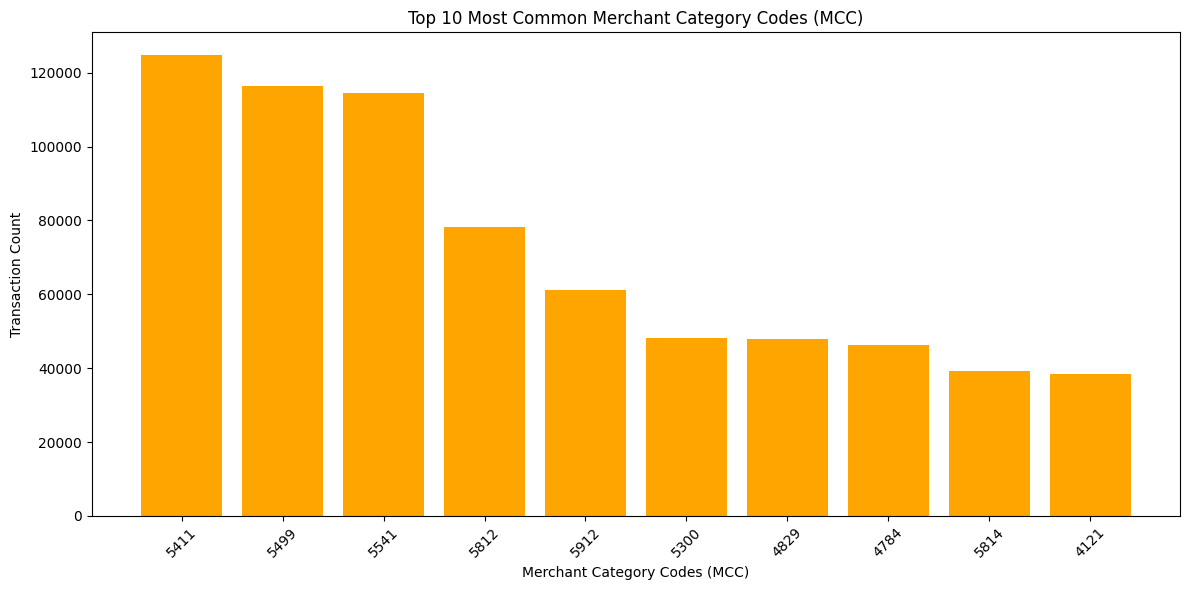

In [4]:
# Goal 4 Identify the most top 10 common Merchant Category Codes (MCC) in the dataset.

most_common_mcc = df.groupBy("mcc") \
    .agg(count("*").alias("transaction_count")) \
    .orderBy(col("transaction_count").desc()) \
    .limit(10)  # Limit to top 10
most_common_mcc.show()

# Convert the result to a Pandas DataFrame for visualization
most_common_mcc_pd = most_common_mcc.toPandas()

# Extract MCCs and their transaction counts
mcc_codes = most_common_mcc_pd["mcc"]
transaction_counts = most_common_mcc_pd["transaction_count"]

# Plot the data using Matplotlib
plt.figure(figsize=(12, 6))
plt.bar(mcc_codes, transaction_counts, color='orange')
plt.xlabel("Merchant Category Codes (MCC)")
plt.ylabel("Transaction Count")
plt.title("Top 10 Most Common Merchant Category Codes (MCC)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()



+------------------+-----------------+
|          use_chip|transaction_count|
+------------------+-----------------+
| Swipe Transaction|           934308|
|Online Transaction|           114267|
+------------------+-----------------+



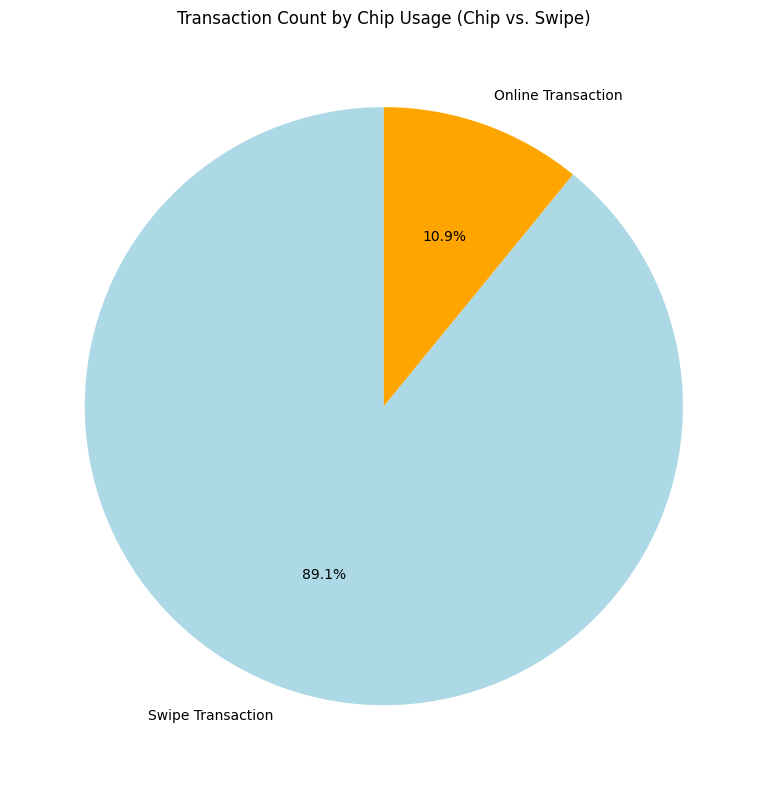

In [5]:
# Goal 5 Calculate the count of transactions categorized by chip usage (chip vs. swipe)
chip_vs_swipe = df.groupBy("use_chip") \
    .agg(count("*").alias("transaction_count"))

chip_vs_swipe.show()
chip_vs_swipe_pd = chip_vs_swipe.toPandas()

# Extract chip usage categories and their transaction counts
usage_categories = chip_vs_swipe_pd["use_chip"].fillna("Unknown")  # Replace NULLs with "Unknown"
transaction_counts = chip_vs_swipe_pd["transaction_count"]

# Plot the data using Matplotlib
plt.figure(figsize=(8, 8))
plt.pie(
    transaction_counts, 
    labels=usage_categories, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['lightblue', 'orange', 'lightgreen']
)
plt.title("Transaction Count by Chip Usage (Chip vs. Swipe)")
plt.tight_layout()

# Show the plot
plt.show()

+---------+------------------+
|client_id|       total_spent|
+---------+------------------+
|     1512| 39677.21994024515|
|      467|41454.180057525635|
|      125|19001.010006546974|
|      451|26073.770025014877|
|     1669|  29527.0000487566|
|      944| 84490.94001445174|
|      870|45425.929947167635|
|     1241| 101050.9899892211|
|     1808| 22952.39998102188|
|     1746| 38495.24997615814|
|     1361|  28422.3399477005|
|      447|29778.980138052255|
|     1528|116257.43995475769|
|     1903| 44842.86006450653|
|      613|38463.910070836544|
|     1445| 30658.90002846718|
|     1500|  43559.2899825573|
|     1897|59195.509947925806|
|     1957|  78925.8800842762|
|     1695|  43812.4800286293|
+---------+------------------+
only showing top 20 rows



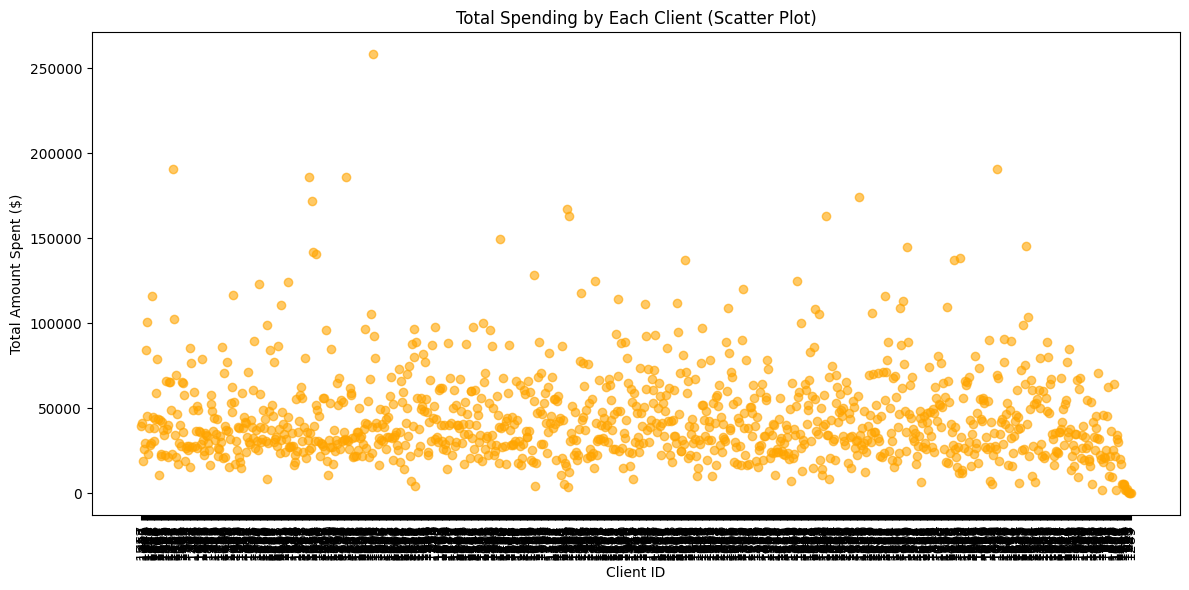

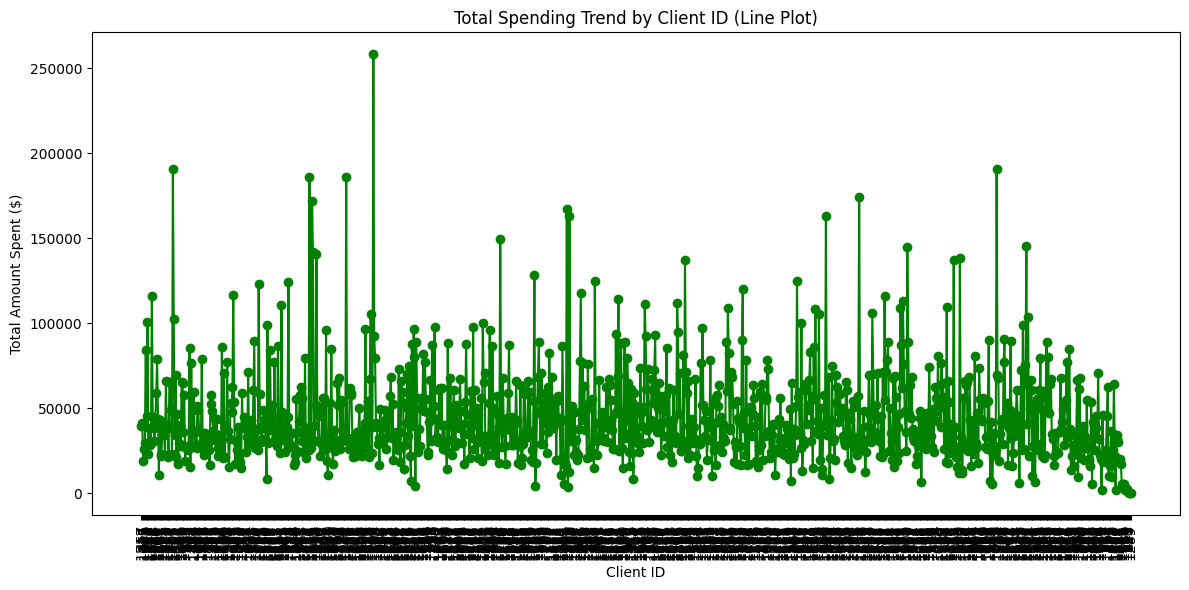

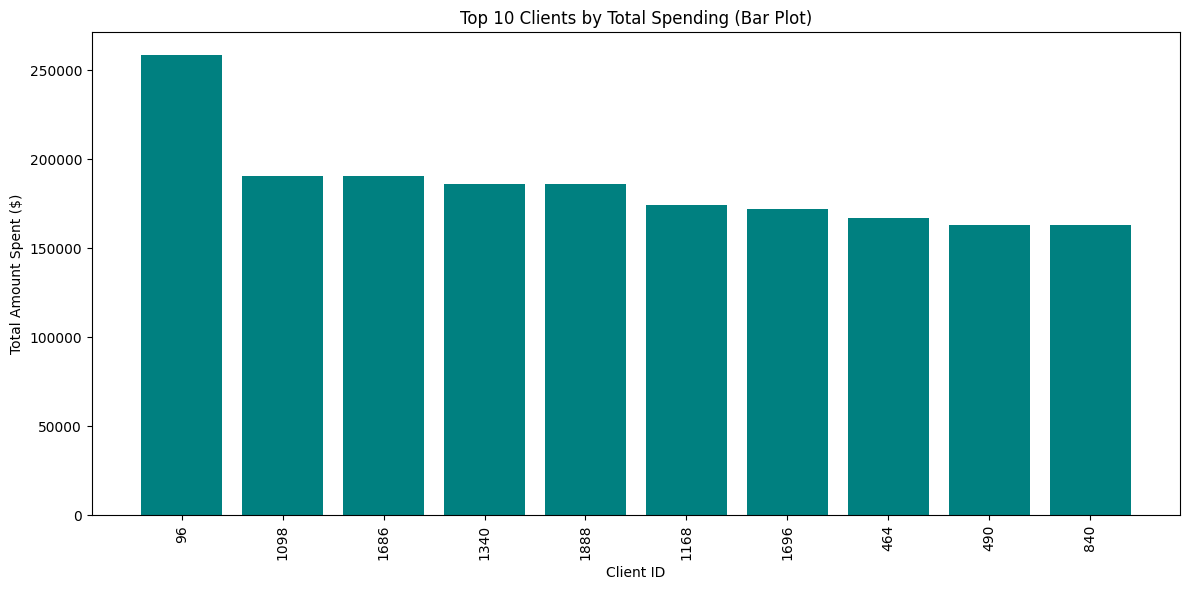

In [6]:
# Goal 6 Calculate the total amount spent by each client.

from pyspark.sql.functions import sum

total_spent_by_client = df.groupBy("client_id") \
    .agg(sum("clean_amount").alias("total_spent"))

total_spent_by_client.show()

total_spent_pd = total_spent_by_client.toPandas()

# Extract client IDs and their total spending
client_ids = total_spent_pd["client_id"]
total_spent = total_spent_pd["total_spent"]

# Scatter Plot for all clients to show distribution
plt.figure(figsize=(12, 6))
plt.scatter(client_ids, total_spent, color="orange", alpha=0.6, marker='o')
plt.xlabel("Client ID")
plt.ylabel("Total Amount Spent ($)")
plt.title("Total Spending by Each Client (Scatter Plot)")
plt.xticks(rotation=90, ha="center")  # Rotate x-axis labels 90 degrees for better visibility
plt.tight_layout()

# Show the scatter plot
plt.show()

# Line Plot to show the spending trend over client IDs (if IDs are ordered)
plt.figure(figsize=(12, 6))
plt.plot(client_ids, total_spent, color="green", linestyle='-', marker='o')
plt.xlabel("Client ID")
plt.ylabel("Total Amount Spent ($)")
plt.title("Total Spending Trend by Client ID (Line Plot)")
plt.xticks(rotation=90, ha="center")  # Rotate x-axis labels 90 degrees for better visibility
plt.tight_layout()

# Show the line plot
plt.show()

# Bar Plot for the Top 10 Clients by Total Spending
top_10_clients = total_spent_by_client.orderBy(col("total_spent").desc()).limit(10)

# Convert top 10 clients to Pandas DataFrame for visualization
top_10_clients_pd = top_10_clients.toPandas()

# Extract client IDs and their total spending
top_10_client_ids = top_10_clients_pd["client_id"]
top_10_total_spent = top_10_clients_pd["total_spent"]

# Bar Plot for the Top 10 Clients by Total Spending
plt.figure(figsize=(12, 6))
plt.bar(top_10_client_ids, top_10_total_spent, color="teal")
plt.xlabel("Client ID")
plt.ylabel("Total Amount Spent ($)")
plt.title("Top 10 Clients by Total Spending (Bar Plot)")
plt.xticks(rotation=90, ha="center")  # Rotate x-axis labels 90 degrees for better visibility
plt.tight_layout()

# Show the bar plot
plt.show()

+--------------+----------------------+
|merchant_state|unique_merchants_count|
+--------------+----------------------+
|        Russia|                     4|
|            SC|                   623|
|            AZ|                   689|
|            LA|                   575|
|        Sweden|                     5|
|            MN|                   710|
|   Philippines|                     9|
|     Singapore|                     3|
|            NJ|                   986|
|            DC|                   112|
|       Germany|                    45|
|        Jordan|                     2|
|            OR|                   435|
|        France|                    32|
|        Greece|                    20|
|        Taiwan|                     2|
|            VA|                   839|
|          NULL|                   205|
|       Belgium|                     4|
|            RI|                   211|
+--------------+----------------------+
only showing top 20 rows



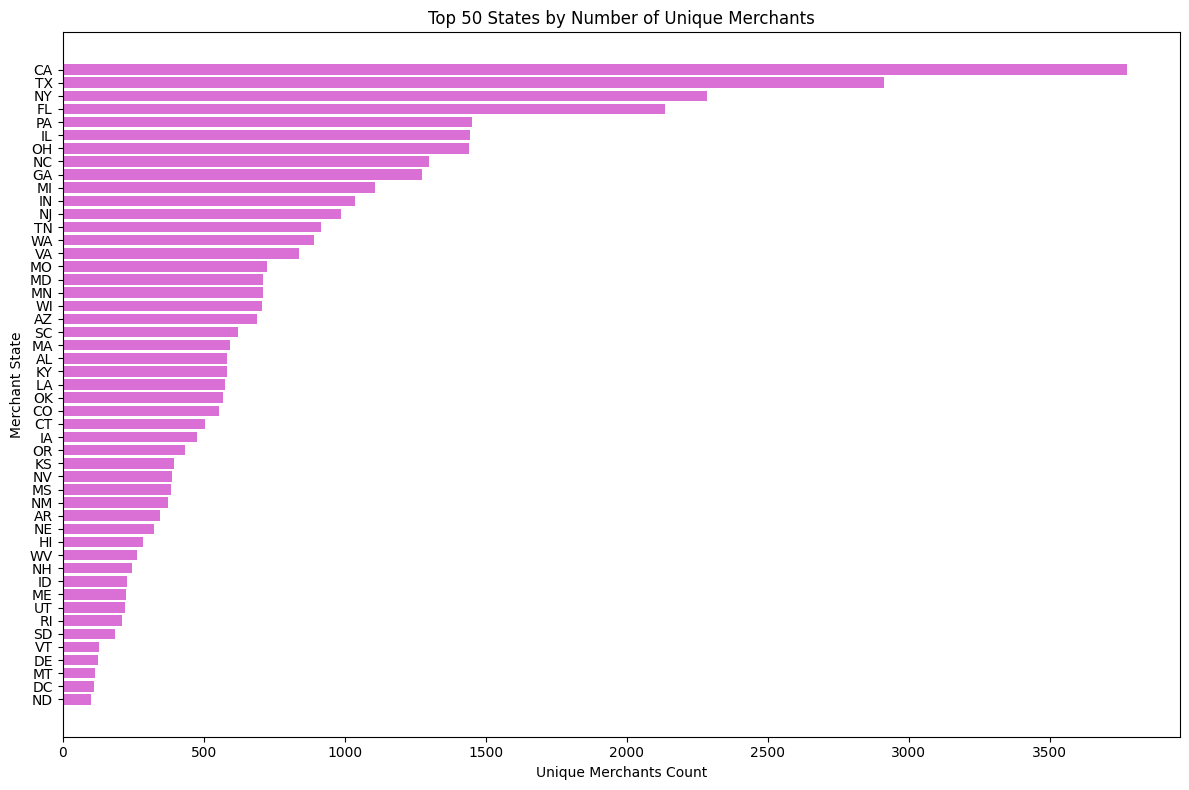

In [7]:
# Goal 7 Count the number of unique merchants in each state.

from pyspark.sql.functions import countDistinct
unique_merchants_by_state = df.groupBy("merchant_state") \
    .agg(countDistinct("merchant_id").alias("unique_merchants_count"))

unique_merchants_by_state.show()
unique_merchants_by_state = unique_merchants_by_state.orderBy("unique_merchants_count", ascending=False).limit(50)

# Convert to Pandas DataFrame for visualization
unique_merchants_pd = unique_merchants_by_state.toPandas()

# Drop rows where `merchant_state` or `unique_merchants_count` is null
unique_merchants_pd = unique_merchants_pd.dropna(subset=["merchant_state", "unique_merchants_count"])

# Extract states and their unique merchant counts
states = unique_merchants_pd["merchant_state"]
unique_merchants_count = unique_merchants_pd["unique_merchants_count"]

# Plot the data using Matplotlib
plt.figure(figsize=(12, 8))
plt.barh(states, unique_merchants_count, color="orchid")
plt.xlabel("Unique Merchants Count")
plt.ylabel("Merchant State")
plt.title("Top 50 States by Number of Unique Merchants")
plt.gca().invert_yaxis()  # Invert y-axis for better readability (largest at the top)
plt.tight_layout()

# Show the plot
plt.show()
